In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
import wave
import sounddevice as sd
from librosa.core import load
from collections import OrderedDict
from scipy import fftpack

In [4]:
song_path = './data/2305.wav'
annotations_path = './data/2305.csv'

In [5]:
annotations = pd.read_csv(annotations_path)
annotations

,start_time,end_time,instrument,note,start_beat,end_beat,note_value
0,1502,127454,1,54,0.0000,4.00,Whole
1,1502,38878,1,57,0.0000,0.50,Eighth
2,38878,53725,1,73,0.5000,0.50,Eighth
3,53725,64990,1,59,1.0000,0.50,Eighth
4,53725,59870,1,74,1.0000,0.25,Sixteenth
...,...,...,...,...,...,...,...
614,2493406,2508766,1,65,93.8375,0.25,Sixteenth
615,2502622,2727902,1,42,94.0000,2.00,Half
616,2508766,2740702,1,66,94.0875,2.00,Half
617,2508766,2740702,1,58,94.0875,2.00,Half


In [6]:
data, sampling_rate = load(song_path)

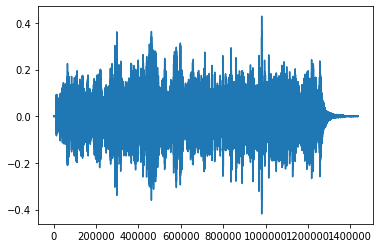

In [7]:
plt.plot(data);

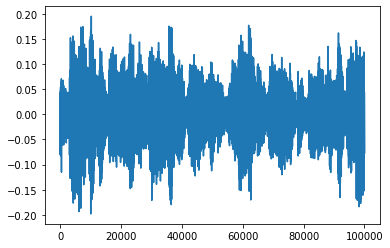

In [9]:
data_part = data[100000:200000]
plt.plot(data_part)

In [10]:
# part_annotations = annotations[annotations['start_time'] >= 178654 & annotations['end_time'] >= 252381]
data_part_annotations = annotations[
    (annotations['start_time'] >= 100000) & 
    (annotations['start_time'] <= 200000)
]
data_part_annotations

,start_time,end_time,instrument,note,start_beat,end_beat,note_value
13,103390,115678,1,56,3.00,0.50,Eighth
14,103390,110046,1,71,3.00,0.25,Sixteenth
15,110046,115678,1,69,3.25,0.25,Sixteenth
16,115678,121310,1,68,3.50,0.25,Sixteenth
17,121310,127454,1,71,3.75,0.25,Sixteenth
18,127454,140766,1,54,4.00,0.50,Eighth
19,127454,140766,1,42,4.00,0.50,Eighth
20,127454,133598,1,69,4.00,0.25,Sixteenth
21,133598,140766,1,68,4.25,0.25,Sixteenth
22,140766,156126,1,54,4.50,0.50,Eighth


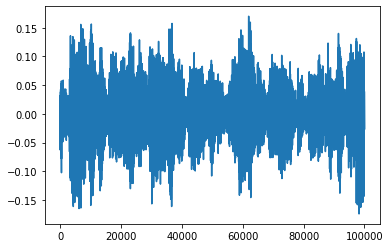

In [15]:
data_smooth = pd.Series(data_part).rolling(window=10).mean().fillna(0).to_numpy().copy()
plt.plot(data_smooth)

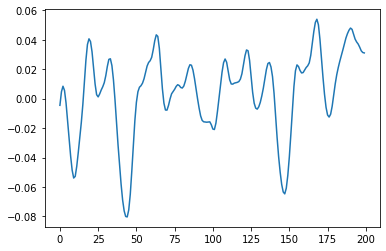

In [16]:
plt.plot(data_part[:200])

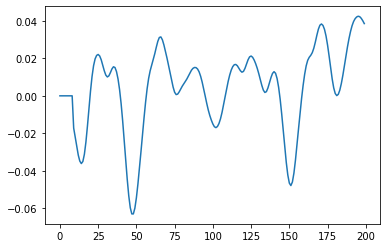

In [17]:
plt.plot(data_smooth[:200])

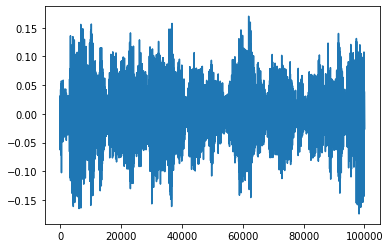

In [21]:
data_cleaned = data_smooth.copy()

threshold = 0.02

data_cleaned[abs(data_cleaned) < threshold] = 0
plt.plot(data_cleaned)

array([[1.60978042, 0.28323447, 0.39888029, ..., 0.85532119, 0.39888029,
        0.28323447],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

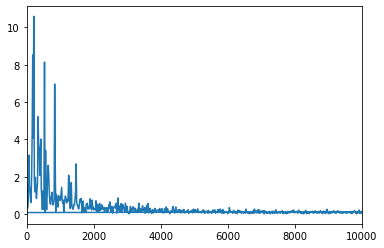

In [22]:
window_size = int(sampling_rate / 32 * 2) # for minimum catching 1/32 notes

fft = np.zeros((len(data_cleaned), window_size))
# print(fft.shape)

for i in range(0, len(data_cleaned), window_size):
#     print(freqs.shape)
    data_window = data_cleaned[i:i+window_size]
    if len(data_window) != window_size: continue
#     print(data_window.shape)
    freqs = np.fft.fftfreq(len(data_window), d=1/sampling_rate)
    X = np.abs(np.fft.fft(data_window))
    plt.xlim(0, 10000)
    plt.plot(freqs, X.real)
#     print(freqs.shape)
    fft[i] = X
    break
#     break

# plt.plot(fft)
fft

In [20]:
from scipy import signal

freqs, times, Sx = signal.spectrogram(data, fs=sampling_rate, window='hanning',
                                      nperseg=1024, noverlap=1024 - 100,
                                      detrend=False, scaling='spectrum')

/home/pandrii000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


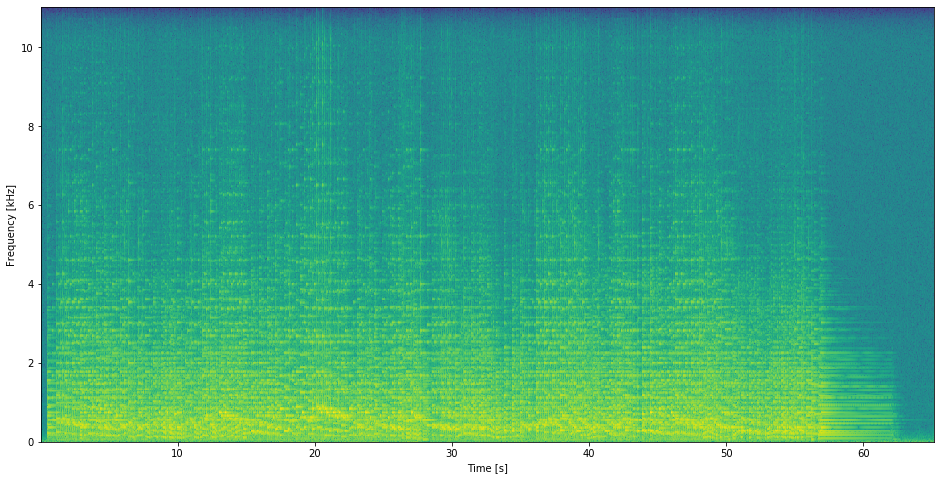

In [21]:
f, ax = plt.subplots(figsize=(16, 8))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');